## 라이브러리 설치 및 호출

In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install konlpy
# !apt-get update -qq
# !apt-get install fonts-nanum* -qq
# pip install transformers
# !pip install sentence-transformers
# !pip install spacy
# !python -m spacy download en_core_web_sm

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification
import torch
from sentence_transformers import SentenceTransformer, util
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.metrics.pairwise import cosine_similarity

from collections import Counter
from konlpy.tag import Okt  # KoNLPy의 Okt 형태소 분석기 사용
from wordcloud import WordCloud

import warnings
warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')

import seaborn as sns
%matplotlib inline
# plt.rc('font', family='Malgun Gothic')  # 맑은 고딕
plt.rc('font', family = 'NanumBarunGothic')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 데이터 로드

In [ ]:
## jupyter ##
# df1 = pd.read_csv('고민 매칭된이야기 평가지 A유형(응답)의 학생분들과 - 설문지 응답 시트1.csv')
# df2 = pd.read_csv('고민 매칭된이야기 평가지 B유형(응답)의 학생분들과 - 설문지 응답 시트1.csv')

## colab ##
df1 = pd.read_csv('/content/drive/MyDrive/202308_thesis/고민 매칭된이야기 평가지 A유형(응답)의 학생분들과 - 설문지 응답 시트1.csv')
df2 = pd.read_csv('/content/drive/MyDrive/202308_thesis/고민 매칭된이야기 평가지 B유형(응답)의 학생분들과 - 설문지 응답 시트1.csv')


## 데이터 전처리 - runtime error 제거

In [ ]:
old_columns = df1.columns.tolist()
new_columns = ['날짜', '이메일', '만나이', '성별',
               '고민1', '매칭답변1', '매칭평가1', '표현강도1', '표현태도1',
               '위안정도1', '연관정도1', '매칭정도1', '문맥정도1',
               '고민2', '매칭답변2', '매칭평가2', '표현강도2', '표현태도2',
               '위안정도2', '연관정도2', '매칭정도2', '문맥정도2',
               '고민3', '매칭답변3', '매칭평가3', '표현강도3', '표현태도3',
               '위안정도3', '연관정도3', '매칭정도3', '문맥정도3',
               '종합만족도', '반복횟수', '추천의향', '만족이유', '만족답변', '불만족이유', '불만족답변']

rename_df1 = df1.rename(columns=dict(zip(old_columns, new_columns)))

In [ ]:
rename_df1

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,연관정도3,매칭정도3,문맥정도3,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변
0,2022. 12. 12 오후 8:19:52,chohyunkm@gmail.com,28,1,평소 한번 걱정을 하기 시작하면 끝도 없이 꼬리에 꼬리를 물고 걱정을 합니다.,경험링크에 들어가 고민 작성 후 클릭을 했는데 결과가 자꾸 이렇게 나옵니다. 카카오...,1,1,1,1,...,0,0,0,1,1,0,0,NaN,2,고민에 대한 결과를 보고 싶은데 자꾸 오류가 나서 불편해요.
1,2022. 12. 12 오후 10:21:19,parkjooha14@gmail.com,34,0,나를 싫어하는 사람들이 있을까 걱정이에요,RuntimeError: CUDA out of memory. Tried to all...,1,1,1,1,...,0,0,0,1,1,0,0,NaN,2,시스템 오류가 있는 듯 합니다. 어떤 문장을 쓰든간에 에러 문구가 뜨고 pc가 아닌...
2,2022. 12. 12 오후 10:29:36,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,5,5,4,2,...,0,0,1,4,3,6,1,NaN,0,NaN
3,2022. 12. 12 오후 10:46:29,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,5,5,4,4,...,3,1,1,4,1,0,0,NaN,2,고쳐지지않음
4,2022. 12. 13 오전 10:05:56,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,4,4,5,4,...,2,0,1,4,4,7,2,아예 해결이 되는 답변은 아니지만 어느 정도 생각은 할 수 있게 해줌,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
626,2022. 12. 19 오후 11:59:52,dbsk061828@gmail.com,25,1,잠을 깊게 자는게 힘들어요,많이 답답하실것 같아요. 그럴땐 창문을 활짝 열고 바람을 쐬어보거나 책을 읽어보는 ...,4,4,4,4,...,1,0,1,4,3,7,1,NaN,1,NaN
627,2022. 12. 20 오전 12:05:16,tjslrk0720@gmail.com,39,1,초등학생 딸이 학교 가기 싫어 하는데 어떻게 하면 될까요?,학교가 당신을 힘들게 하는군요. 꼭 학교를 다니지 않아도 돼요. 인생은 정말 다양하...,3,3,2,2,...,0,0,0,1,2,0,0,NaN,1,NaN
628,2022. 12. 20 오전 3:11:31,transming81@gmail.com,41,1,아이돌처럼 춤추고 노래하고 싶어,연습한 만큼 좋은 결과 있기를 바라요. 내일 떨지 않고 잘 할 수 있을 거예요. 파이팅!,3,5,5,4,...,1,1,1,4,5,7,1,NaN,0,NaN
629,2022. 12. 20 오후 11:47:38,rlagmlfo89@gmail.com,33,1,영어를 잘 하고 싶어요,많은 사람들이 그 목표조차 찾지 못해 쓰러지는데 OO님은 목표도 있고 그 목표를 향...,1,5,5,1,...,0,0,1,1,3,1,0,NaN,1,NaN


In [ ]:
old_columns2 = df2.columns.tolist()
new_columns2 = ['날짜', '이메일', '만나이', '성별',
               '고민1', '매칭답변1', '매칭평가1', '표현강도1', '표현태도1',
               '위안정도1', '연관정도1', '매칭정도1', '문맥정도1',
               '고민2', '매칭답변2', '매칭평가2', '표현강도2', '표현태도2',
               '위안정도2', '연관정도2', '매칭정도2', '문맥정도2',
               '고민3', '매칭답변3', '매칭평가3', '표현강도3', '표현태도3',
               '위안정도3', '연관정도3', '매칭정도3', '문맥정도3',
               '종합만족도', '반복횟수', '추천의향', '만족이유', '만족답변', '불만족이유', '불만족답변']

rename_df2 = df2.rename(columns=dict(zip(old_columns2, new_columns2)))

In [ ]:
rename_df2

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,연관정도3,매칭정도3,문맥정도3,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변
0,2022. 12. 12 오후 8:07:19,lshhs89@gmail.com,34,1,요즘 쉽게 짜증이 나고 예민해져서 다른 사람들한테 쉽게 화를 내요,댓글:자신의 감정을 잘 표현하지 못하는 것은 사회적으로 큰 문제가 될 수 있습니다....,2,2,3,2,...,2,1,1,3,3,6,2,찾아가서 상담하지 않고 비대면으로도 가능해서,2,정확한 답변이 아니고 내가 중심이 아닌 다른 이야기만 하는것 같음
1,2022. 12. 12 오후 8:08:06,dkdlwpskj@gmail.com,25,0,저는 학업스트레스 때문에 고민입니다,댓글: 저도 그랬어요. 하지만 그 스트레스를 풀려고 노력해보세요! 예를 들어 운동을...,4,4,5,4,...,3,1,1,4,4,6,0,NaN,1,NaN
2,2022. 12. 12 오후 8:14:19,dladpwl33@gmail.com,22,1,해야 할 일은 많은데 너무 나태해져 아무것도 안 하게 된다.,댓글:저는 해야 할 일이 있으면 그것을 다 끝내고 쉬는 편입니다. 하지만 다른 사람...,2,3,4,3,...,2,1,1,3,3,4,0,NaN,2,내 고민과 전혀 다른 답변이 나오는 것 같다.
3,2022. 12. 12 오후 8:29:07,csj113711@gmail.com,28,1,수면장애가 식이장애로까지 번져 건강이 악화됨을 생생하게 느끼고 있다.,"식이장애는 신체적, 정신적으로 매우 힘든 병입니다. 자신의 몸과 마음을 사랑하고 아...",4,4,5,4,...,3,1,1,4,4,6,2,누군가는 짧은 임팩트 있는 말에 힘을 얻기도 또 누군가는 자신의 마음을 어루만져 아...,2,문장 자체가 말이 안되는 것은 아니지만 사례인용이나 문구인용시에 갑자기 흐름이 깨져...
4,2022. 12. 12 오후 8:35:00,mozzizog3@gmail.com,이소현,1,"직장에서 인정받고 싶은데, 실력이 따라주질 않는다.",댓글:실력은 기본이고 인간관계가 중요하다. 사람을 대할 때는 진심으로 대하라. 그리...,4,4,5,2,...,1,1,1,3,4,2,0,NaN,2,내용이 너무 복사 붙여넣기고 끼워맞추기 인듯하다
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,2022. 12. 20 오전 12:30:17,heyyjin0329@gmail.com,26,1,기분이 태도가 되는 경우가 많아요,댓글:저도 그래요. 기분이 안좋으면 주변 사람들에게 짜증을 많이 내요. 그래서 저는...,5,5,5,4,...,3,1,1,4,3,8,1,NaN,0,NaN
538,2022. 12. 20 오전 8:41:09,letmego1009sky@gmail.com,35,1,유년시절 왕따를 당한 기억이 있고 친구가 많지 않아서 내가 잘살고 있는지 걱정이되고...,댓글: 내담자가 어릴때부터 마음의 상처로 인해 지금까지 힘들어하고 있는 것 같다. ...,2,3,3,2,...,1,1,1,4,4,8,2,말하기 어려운 부분도 대면하고 말하지 않아서 더 솔직하게 털어놓을수 있는거같아요,0,NaN
539,2022. 12. 20 오후 7:17:20,singasong33@daum.net,55,1,부모님이 나이가 점점 많아져 가는데 멀리 떨어져 살아서 돌봐 드리지 못해 걱정이다.,댓글: 부모님은 우리를 위해 평생을 희생하고 사셨다. 이제는 자식들이 부모님을 보살...,3,3,1,1,...,0,0,1,2,2,1,0,NaN,2,내가 한 고민과 전혀 다른 이야기가 답변으로 적혀 있어서 한 치의 도움도 받지 못했다.
540,2022. 12. 21 오후 5:02:00,foresty2210@gmail.com,24,1,앞으로 혼자서 잘 살 수 있을까요,댓글:혼자서도 충분히 잘 살아갈 수 있다.\n피드백:나는 내가 생각한 것보다 더 강하다.,4,2,1,5,...,1,0,1,4,2,6,2,세번 째 질문에 대한 올바른 답은 아니었지만 매칭돤 이야기가 여러 질문을 입력하면서...,2,질문 내용에 대해 답변 얻기가 대체로 어렵습니다..


In [ ]:
print(rename_df1.shape, rename_df2.shape)

(631, 38) (542, 38)


In [ ]:
# '매칭답변1', '매칭답변2', '매칭답변3' 중 'RuntimeError'을 포함하는 행 추출
filtered_df1 = rename_df1[rename_df1['매칭답변1'].str.contains('RuntimeError', na=False) | rename_df1['매칭답변2'].str.contains('RuntimeError', na=False) | rename_df1['매칭답변3'].str.contains('RuntimeError', na=False)]
filtered_df1

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,연관정도3,매칭정도3,문맥정도3,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변
0,2022. 12. 12 오후 8:19:52,chohyunkm@gmail.com,28,1,평소 한번 걱정을 하기 시작하면 끝도 없이 꼬리에 꼬리를 물고 걱정을 합니다.,경험링크에 들어가 고민 작성 후 클릭을 했는데 결과가 자꾸 이렇게 나옵니다. 카카오...,1,1,1,1,...,0,0,0,1,1,0,0,NaN,2,고민에 대한 결과를 보고 싶은데 자꾸 오류가 나서 불편해요.
1,2022. 12. 12 오후 10:21:19,parkjooha14@gmail.com,34,0,나를 싫어하는 사람들이 있을까 걱정이에요,RuntimeError: CUDA out of memory. Tried to all...,1,1,1,1,...,0,0,0,1,1,0,0,NaN,2,시스템 오류가 있는 듯 합니다. 어떤 문장을 쓰든간에 에러 문구가 뜨고 pc가 아닌...


In [ ]:
# '매칭답변1', '매칭답변2', '매칭답변3' 중 'RuntimeError'을 포함하는 행 추출
filtered_df2 = rename_df2[rename_df2['매칭답변1'].str.contains('RuntimeError', na=False) | rename_df2['매칭답변2'].str.contains('RuntimeError', na=False) | rename_df2['매칭답변3'].str.contains('RuntimeError', na=False)]
filtered_df2[['매칭답변1', '매칭답변2', '매칭답변3']]

,매칭답변1,매칭답변2,매칭답변3


In [ ]:
rename_df1 = rename_df1.drop([0, 1]).reset_index(drop=True)
rename_df1.head()

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,연관정도3,매칭정도3,문맥정도3,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변
0,2022. 12. 12 오후 10:29:36,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,5,5,4,2,...,0,0,1,4,3,6,1,NaN,0,NaN
1,2022. 12. 12 오후 10:46:29,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,5,5,4,4,...,3,1,1,4,1,0,0,NaN,2,고쳐지지않음
2,2022. 12. 13 오전 10:05:56,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,4,4,5,4,...,2,0,1,4,4,7,2,아예 해결이 되는 답변은 아니지만 어느 정도 생각은 할 수 있게 해줌,0,NaN
3,2022. 12. 13 오전 10:07:02,chohyunkm@gmail.com,27,1,평소 한번 걱정을 하기 시작하면 끝도 없이 꼬리에 꼬리를 물고 걱정을 합니다.,저랑 비슷한 성격을 가지고 계시네요. 사실 소심한 성격 탓이 아닐 수 있어요. 다른...,2,4,4,2,...,3,1,1,2,4,1,0,NaN,2,현재의 다소 두루뭉술한 답변보다 좀 더 구체적인 해결법을 제시해줬으면 좋겠어요. \...
4,2022. 12. 13 오전 10:14:58,ppoo8752@gmail.com,33,1,"한번 화가나면 흥분, 좌절, 슬픔의 감정이 오래 가요",OO님을 응원하는 사람들이 많아요 용기 잃지 마시고 OO님의 몸에 상처를 내지 마세요,2,4,5,3,...,1,0,1,3,2,5,0,NaN,2,고민에 해당되는 답변이 아닌것 같고 영혼 없는 사무적인 느낌이라 공감받지 못한것 같...


In [ ]:
rename_df1['이메일'].nunique()

112

In [ ]:
len(rename_df1)

629

In [ ]:
rename_df2['이메일'].nunique()

108

In [ ]:
len(rename_df2)

542

# 사용량 분석

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
df1_day=rename_df1.groupby('이메일').size().sort_values(ascending=False)
df1_day

이메일
hana31146381@gmail.com     8
nwm21d@gmail.com           8
rlagmlfo89@gmail.com       8
ramses3k0608@gmail.com     8
kyunghyun.ahn@gmail.com    8
                          ..
alswn67867@gmial.com       1
alswn67867@gamil.com       1
kaktalina98@dgu.ac.kr      1
m96268910@gmail.com\n      1
rienneco@gmail.net         1
Length: 112, dtype: int64

In [ ]:
df1_day=pd.DataFrame(df1_day)
df1_day.reset_index(inplace=True)
df1_day

,이메일,0
0,hana31146381@gmail.com,8
1,nwm21d@gmail.com,8
2,rlagmlfo89@gmail.com,8
3,ramses3k0608@gmail.com,8
4,kyunghyun.ahn@gmail.com,8
...,...,...
107,alswn67867@gmial.com,1
108,alswn67867@gamil.com,1
109,kaktalina98@dgu.ac.kr,1
110,m96268910@gmail.com\n,1


In [ ]:
df1_day.columns = ['이메일', 'score']
df1_day

,이메일,score
0,hana31146381@gmail.com,8
1,nwm21d@gmail.com,8
2,rlagmlfo89@gmail.com,8
3,ramses3k0608@gmail.com,8
4,kyunghyun.ahn@gmail.com,8
...,...,...
107,alswn67867@gmial.com,1
108,alswn67867@gamil.com,1
109,kaktalina98@dgu.ac.kr,1
110,m96268910@gmail.com\n,1


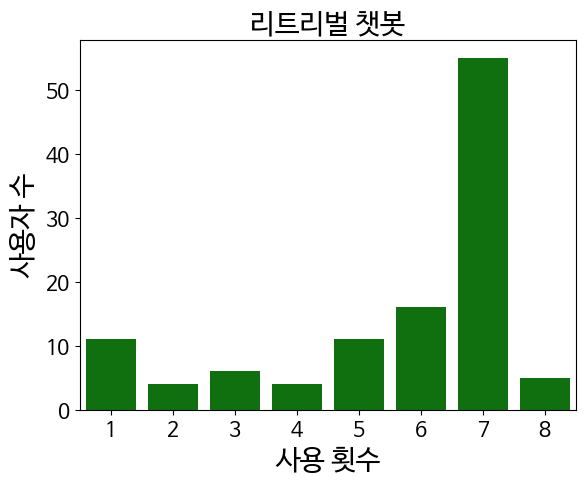

In [ ]:
sns.countplot(data=df1_day,x='score',color='green')
plt.title('리트리벌 챗봇',fontsize=20)
plt.xlabel('사용 횟수',fontsize=20)
plt.ylabel('사용자 수',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [ ]:
df2_day=rename_df2.groupby('이메일').size().sort_values(ascending=False)
df2_day

이메일
mindongee2503@gmail.com     8
wjswlsghkd@gmail.com        8
cys20522@gmail.com          8
heea239@gmail.com           8
heoy9445@gmail.com          8
                           ..
khj091955@gamil.com         1
a02092610352@gmail.com      1
jukjy@naver.com             1
ilhiyoung100@gmail.com\n    1
dkdlwpskj@gmil.com          1
Length: 108, dtype: int64

In [ ]:
df2_day=pd.DataFrame(df2_day)
df2_day.reset_index(inplace=True)
df2_day.columns = ['이메일', 'score']
df2_day

,이메일,score
0,mindongee2503@gmail.com,8
1,wjswlsghkd@gmail.com,8
2,cys20522@gmail.com,8
3,heea239@gmail.com,8
4,heoy9445@gmail.com,8
...,...,...
103,khj091955@gamil.com,1
104,a02092610352@gmail.com,1
105,jukjy@naver.com,1
106,ilhiyoung100@gmail.com\n,1


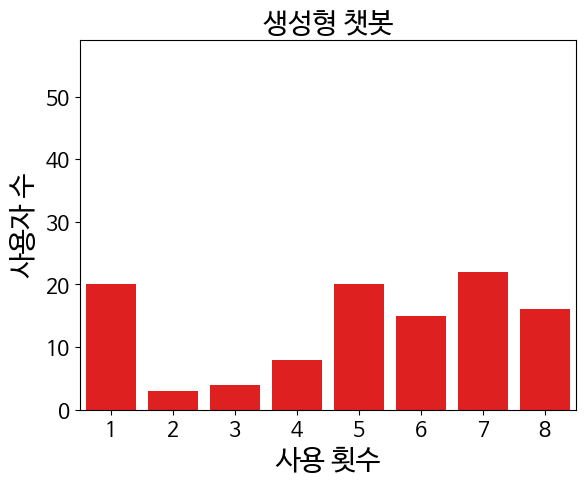

In [ ]:
sns.countplot(data=df2_day,x='score',color='red')
plt.title('생성형 챗봇',fontsize=20)
plt.xlabel('사용 횟수',fontsize=20)
plt.ylabel('사용자 수',fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylim(0, 59)
plt.show()

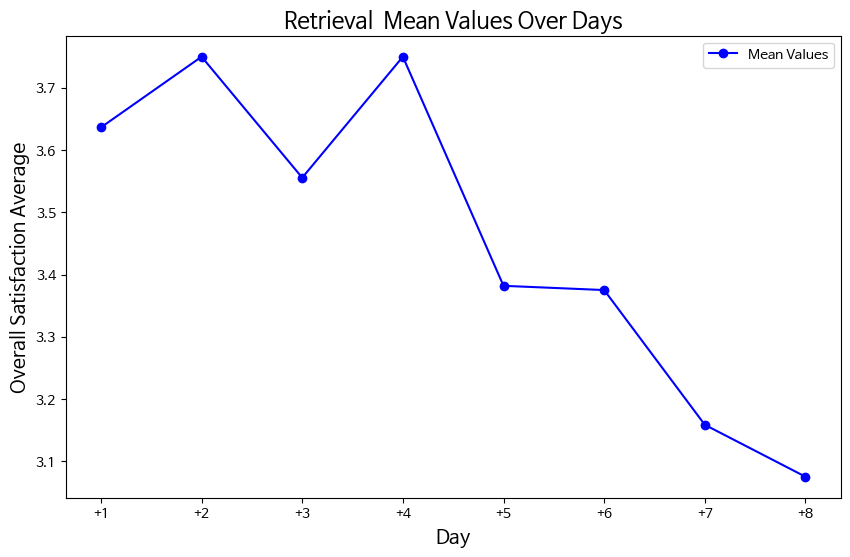

In [ ]:
df1_day8=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==8].index
df1_day7=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==7].index
df1_day6=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==6].index
df1_day5=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==5].index
df1_day4=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==4].index
df1_day3=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==3].index
df1_day2=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==2].index
df1_day1=rename_df1.groupby('이메일').size()[rename_df1.groupby('이메일').size()==1].index

df1_day8=rename_df1[rename_df1['이메일'].isin(df1_day8)]['종합만족도'].mean()
df1_day7=rename_df1[rename_df1['이메일'].isin(df1_day7)]['종합만족도'].mean()
df1_day6=rename_df1[rename_df1['이메일'].isin(df1_day6)]['종합만족도'].mean()
df1_day5=rename_df1[rename_df1['이메일'].isin(df1_day5)]['종합만족도'].mean()
df1_day4=rename_df1[rename_df1['이메일'].isin(df1_day4)]['종합만족도'].mean()
df1_day3=rename_df1[rename_df1['이메일'].isin(df1_day3)]['종합만족도'].mean()
df1_day2=rename_df1[rename_df1['이메일'].isin(df1_day2)]['종합만족도'].mean()
df1_day1=rename_df1[rename_df1['이메일'].isin(df1_day1)]['종합만족도'].mean()

df1_mean=[df1_day1, df1_day2, df1_day3, df1_day4, df1_day5, df1_day6, df1_day7, df1_day8]
dates = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8']

# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프의 크기 설정 (선택 사항)

# 선 그래프 그리기
plt.plot(dates, df1_mean, marker='o', linestyle='-', color='b', label='Mean Values')

# 그래프 제목과 축 레이블 설정
plt.title('Retrieval  Mean Values Over Days',fontsize=16)
plt.xlabel('Day',fontsize=14)
plt.ylabel('Overall Satisfaction Average',fontsize=14)

# 범례 추가 (선택 사항)
plt.legend()

# 그래프 표시 (이 코드는 Jupyter Notebook에서 사용할 경우 필요하지 않음)
plt.show()


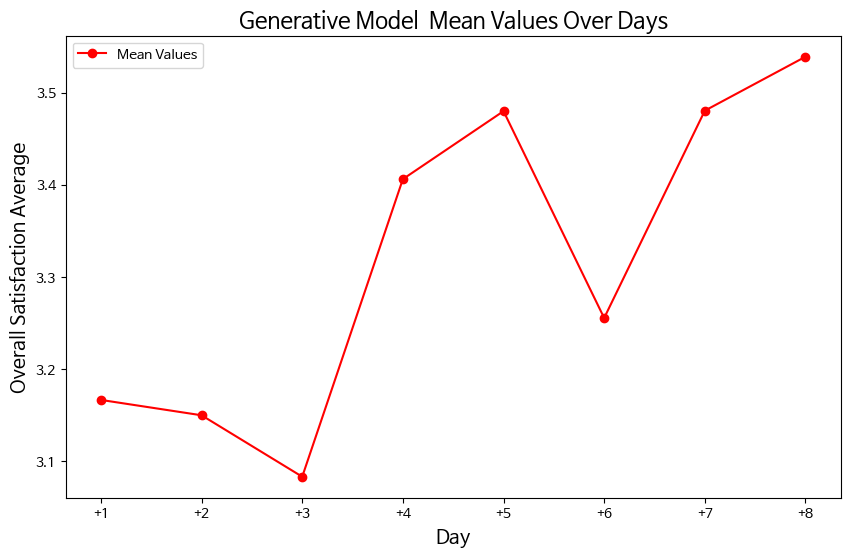

In [ ]:
df2_day8=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==8].index
df2_day7=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==7].index
df2_day6=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==6].index
df2_day5=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==5].index
df2_day4=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==4].index
df2_day3=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==3].index
df2_day2=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==1].index
df2_day1=rename_df2.groupby('이메일').size()[rename_df2.groupby('이메일').size()==2].index

df2_day8=rename_df2[rename_df2['이메일'].isin(df2_day8)]['종합만족도'].mean()
df2_day7=rename_df2[rename_df2['이메일'].isin(df2_day7)]['종합만족도'].mean()
df2_day6=rename_df2[rename_df2['이메일'].isin(df2_day6)]['종합만족도'].mean()
df2_day5=rename_df2[rename_df2['이메일'].isin(df2_day5)]['종합만족도'].mean()
df2_day4=rename_df2[rename_df2['이메일'].isin(df2_day4)]['종합만족도'].mean()
df2_day3=rename_df2[rename_df2['이메일'].isin(df2_day3)]['종합만족도'].mean()
df2_day2=rename_df2[rename_df2['이메일'].isin(df2_day2)]['종합만족도'].mean()
df2_day1=rename_df2[rename_df2['이메일'].isin(df2_day1)]['종합만족도'].mean()


df2_mean=[df2_day1, df2_day2, df2_day3, df2_day4, df2_day5, df2_day6, df2_day7, df2_day8]
dates = ['+1', '+2', '+3', '+4', '+5', '+6', '+7', '+8']

# 그래프 생성
plt.figure(figsize=(10, 6))  # 그래프의 크기 설정 (선택 사항)

# 선 그래프 그리기
plt.plot(dates, df2_mean, marker='o', linestyle='-', color='r', label='Mean Values')

# 그래프 제목과 축 레이블 설정
plt.title('Generative Model  Mean Values Over Days',fontsize=16)
plt.xlabel('Day',fontsize=14)
plt.ylabel('Overall Satisfaction Average',fontsize=14)

# 범례 추가 (선택 사항)
plt.legend()

# 그래프 표시 (이 코드는 Jupyter Notebook에서 사용할 경우 필요하지 않음)
plt.show()


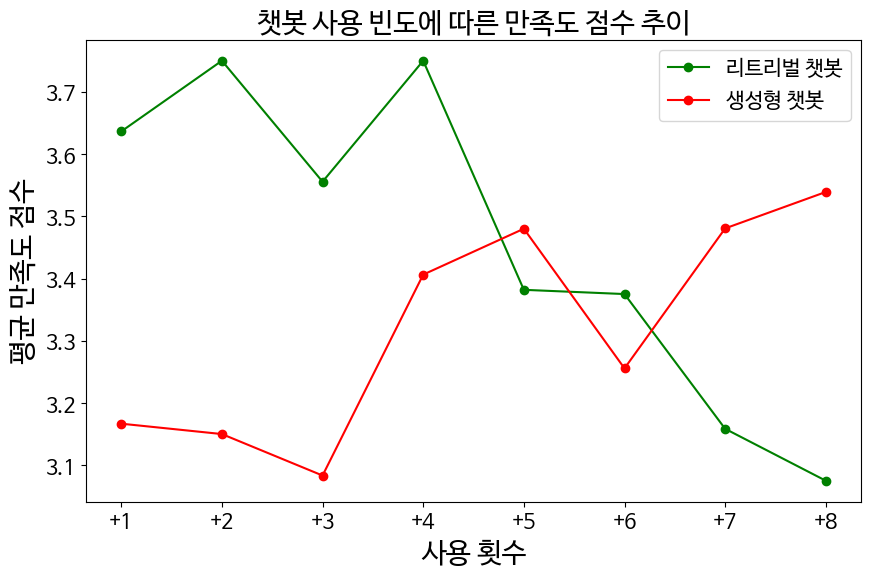

In [ ]:
import matplotlib.pyplot as plt

# 그래프의 크기 설정
plt.figure(figsize=(10, 6))

# 첫 번째 선 그래프 그리기
plt.plot(dates, df1_mean, marker='o', linestyle='-', color='g', label='리트리벌 챗봇')

# 두 번째 선 그래프 그리기
plt.plot(dates, df2_mean, marker='o', linestyle='-', color='r', label='생성형 챗봇')

# 그래프 제목과 축 레이블 설정
plt.title('챗봇 사용 빈도에 따른 만족도 점수 추이', fontsize=20)
plt.xlabel('사용 횟수', fontsize=20)
plt.ylabel('평균 만족도 점수', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# 범례 추가
plt.legend(prop={'size': 15})

# 그래프 표시
plt.show()


## A+B 응답시트 분석

In [ ]:
concat_df = pd.concat([rename_df1, rename_df2], axis = 0)
concat_df.head(3)

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,연관정도3,매칭정도3,문맥정도3,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변
0,2022. 12. 12 오후 10:29:36,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,5,5,4,2,...,0,0,1,4,3,6,1,NaN,0,NaN
1,2022. 12. 12 오후 10:46:29,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,5,5,4,4,...,3,1,1,4,1,0,0,NaN,2,고쳐지지않음
2,2022. 12. 13 오전 10:05:56,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,4,4,5,4,...,2,0,1,4,4,7,2,아예 해결이 되는 답변은 아니지만 어느 정도 생각은 할 수 있게 해줌,0,NaN


In [ ]:
concat_df['이메일'].nunique()

220

In [ ]:
#concat_df.info()

In [ ]:
# 숫자만 남기는 함수 정의
def keep_numbers_only(input_string):
    return re.sub(r'\D', '', input_string)

concat_df['만나이2'] = concat_df['만나이'].apply(keep_numbers_only)
concat_df['만나이2'] = pd.to_numeric(concat_df['만나이2'], errors='coerce')
concat_df['만나이2'] = concat_df['만나이2'].fillna(concat_df['만나이2'].mean())
concat_df['만나이2'].astype(int)

0      25
1      36
2      34
3      27
4      33
       ..
537    26
538    35
539    55
540    24
541    55
Name: 만나이2, Length: 1171, dtype: int64

In [ ]:
binss = [0, 20, 30, 40, 50, 60, 70, 80, 90, 100]

In [ ]:
concat_df['만나이2']=pd.cut(concat_df['만나이2'],bins=binss,labels=['미성년자','20대','30대','40대','50대','60대','70대','80대','90대'])

In [ ]:
concat_df.head(2)

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,매칭정도3,문맥정도3,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변,만나이2
0,2022. 12. 12 오후 10:29:36,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,5,5,4,2,...,0,1,4,3,6,1,NaN,0,NaN,20대
1,2022. 12. 12 오후 10:46:29,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,5,5,4,4,...,1,1,4,1,0,0,NaN,2,고쳐지지않음,30대


In [ ]:
df = concat_df.copy()
# df = df.head(10)
df.shape

(1171, 39)

In [ ]:
df.columns

Index(['날짜', '이메일', '만나이', '성별', '고민1', '매칭답변1', '매칭평가1', '표현강도1', '표현태도1',
       '위안정도1', '연관정도1', '매칭정도1', '문맥정도1', '고민2', '매칭답변2', '매칭평가2', '표현강도2',
       '표현태도2', '위안정도2', '연관정도2', '매칭정도2', '문맥정도2', '고민3', '매칭답변3', '매칭평가3',
       '표현강도3', '표현태도3', '위안정도3', '연관정도3', '매칭정도3', '문맥정도3', '종합만족도', '반복횟수',
       '추천의향', '만족이유', '만족답변', '불만족이유', '불만족답변', '만나이2'],
      dtype='object')

In [ ]:
# df['매칭평가'] = df[['매칭평가1', '매칭평가2', '매칭평가3']].mean(axis=1)
# df['표현강도'] = df[['표현강도1', '표현강도2', '표현강도3']].mean(axis=1)

# # 결과 확인
# df.head()

In [ ]:
# 각 평가 항목에 대한 평균 점수
evaluation_columns = ['매칭평가', '표현강도', '표현태도', '위안정도', '연관정도', '매칭정도', '문맥정도']
for eval_col in evaluation_columns:
    df[f'{eval_col}평균'] = df[[f'{eval_col}1', f'{eval_col}2', f'{eval_col}3']].mean(axis=1).round(1)

df.head()

,날짜,이메일,만나이,성별,고민1,매칭답변1,매칭평가1,표현강도1,표현태도1,위안정도1,...,불만족이유,불만족답변,만나이2,매칭평가평균,표현강도평균,표현태도평균,위안정도평균,연관정도평균,매칭정도평균,문맥정도평균
0,2022. 12. 12 오후 10:29:36,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,5,5,4,2,...,0,NaN,20대,3.7,4.3,4.0,3.0,0.7,0.7,1.0
1,2022. 12. 12 오후 10:46:29,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,5,5,4,4,...,2,고쳐지지않음,30대,4.7,4.3,4.0,4.0,3.0,1.0,1.0
2,2022. 12. 13 오전 10:05:56,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,4,4,5,4,...,0,NaN,30대,3.0,3.7,4.0,4.0,1.7,0.3,1.0
3,2022. 12. 13 오전 10:07:02,chohyunkm@gmail.com,27,1,평소 한번 걱정을 하기 시작하면 끝도 없이 꼬리에 꼬리를 물고 걱정을 합니다.,저랑 비슷한 성격을 가지고 계시네요. 사실 소심한 성격 탓이 아닐 수 있어요. 다른...,2,4,4,2,...,2,현재의 다소 두루뭉술한 답변보다 좀 더 구체적인 해결법을 제시해줬으면 좋겠어요. \...,20대,3.3,3.3,3.0,2.0,2.3,0.7,1.0
4,2022. 12. 13 오전 10:14:58,ppoo8752@gmail.com,33,1,"한번 화가나면 흥분, 좌절, 슬픔의 감정이 오래 가요",OO님을 응원하는 사람들이 많아요 용기 잃지 마시고 OO님의 몸에 상처를 내지 마세요,2,4,5,3,...,2,고민에 해당되는 답변이 아닌것 같고 영혼 없는 사무적인 느낌이라 공감받지 못한것 같...,30대,2.3,4.3,5.0,2.7,0.3,0.3,1.0


In [ ]:
df.columns

Index(['날짜', '이메일', '만나이', '성별', '고민1', '매칭답변1', '매칭평가1', '표현강도1', '표현태도1',
       '위안정도1', '연관정도1', '매칭정도1', '문맥정도1', '고민2', '매칭답변2', '매칭평가2', '표현강도2',
       '표현태도2', '위안정도2', '연관정도2', '매칭정도2', '문맥정도2', '고민3', '매칭답변3', '매칭평가3',
       '표현강도3', '표현태도3', '위안정도3', '연관정도3', '매칭정도3', '문맥정도3', '종합만족도', '반복횟수',
       '추천의향', '만족이유', '만족답변', '불만족이유', '불만족답변', '만나이2', '매칭평가평균', '표현강도평균',
       '표현태도평균', '위안정도평균', '연관정도평균', '매칭정도평균', '문맥정도평균'],
      dtype='object')

In [ ]:
df[['매칭평가1', '표현강도1', '표현태도1', '위안정도1', '연관정도1', '매칭정도1', '문맥정도1',
   '매칭평가2', '표현강도2', '표현태도2', '위안정도2', '연관정도2', '매칭정도2', '문맥정도2',
   '매칭평가3', '표현강도3', '표현태도3', '위안정도3', '연관정도3', '매칭정도3', '문맥정도3',
   '매칭평가평균', '표현강도평균', '표현태도평균', '위안정도평균', '연관정도평균', '매칭정도평균', '문맥정도평균']]

,매칭평가1,표현강도1,표현태도1,위안정도1,연관정도1,매칭정도1,문맥정도1,매칭평가2,표현강도2,표현태도2,...,연관정도3,매칭정도3,문맥정도3,매칭평가평균,표현강도평균,표현태도평균,위안정도평균,연관정도평균,매칭정도평균,문맥정도평균
0,5,5,4,2,1,1,1,5,5,5,...,0,0,1,3.7,4.3,4.0,3.0,0.7,0.7,1.0
1,5,5,4,4,3,1,1,5,4,4,...,3,1,1,4.7,4.3,4.0,4.0,3.0,1.0,1.0
2,4,4,5,4,3,1,1,1,3,3,...,2,0,1,3.0,3.7,4.0,4.0,1.7,0.3,1.0
3,2,4,4,2,1,0,1,4,2,2,...,3,1,1,3.3,3.3,3.0,2.0,2.3,0.7,1.0
4,2,4,5,3,0,0,1,3,5,5,...,1,0,1,2.3,4.3,5.0,2.7,0.3,0.3,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
537,5,5,5,4,3,1,1,2,3,3,...,3,1,1,3.7,4.3,3.7,4.0,2.7,0.7,1.0
538,2,3,3,2,1,0,0,4,4,4,...,1,1,1,3.3,3.3,3.0,3.0,1.3,0.7,0.7
539,3,3,1,1,1,1,1,4,2,2,...,0,0,1,2.7,2.7,1.3,1.3,1.3,0.7,1.0
540,4,2,1,5,2,1,1,3,5,4,...,1,0,1,3.3,3.7,2.3,3.7,2.0,0.7,1.0


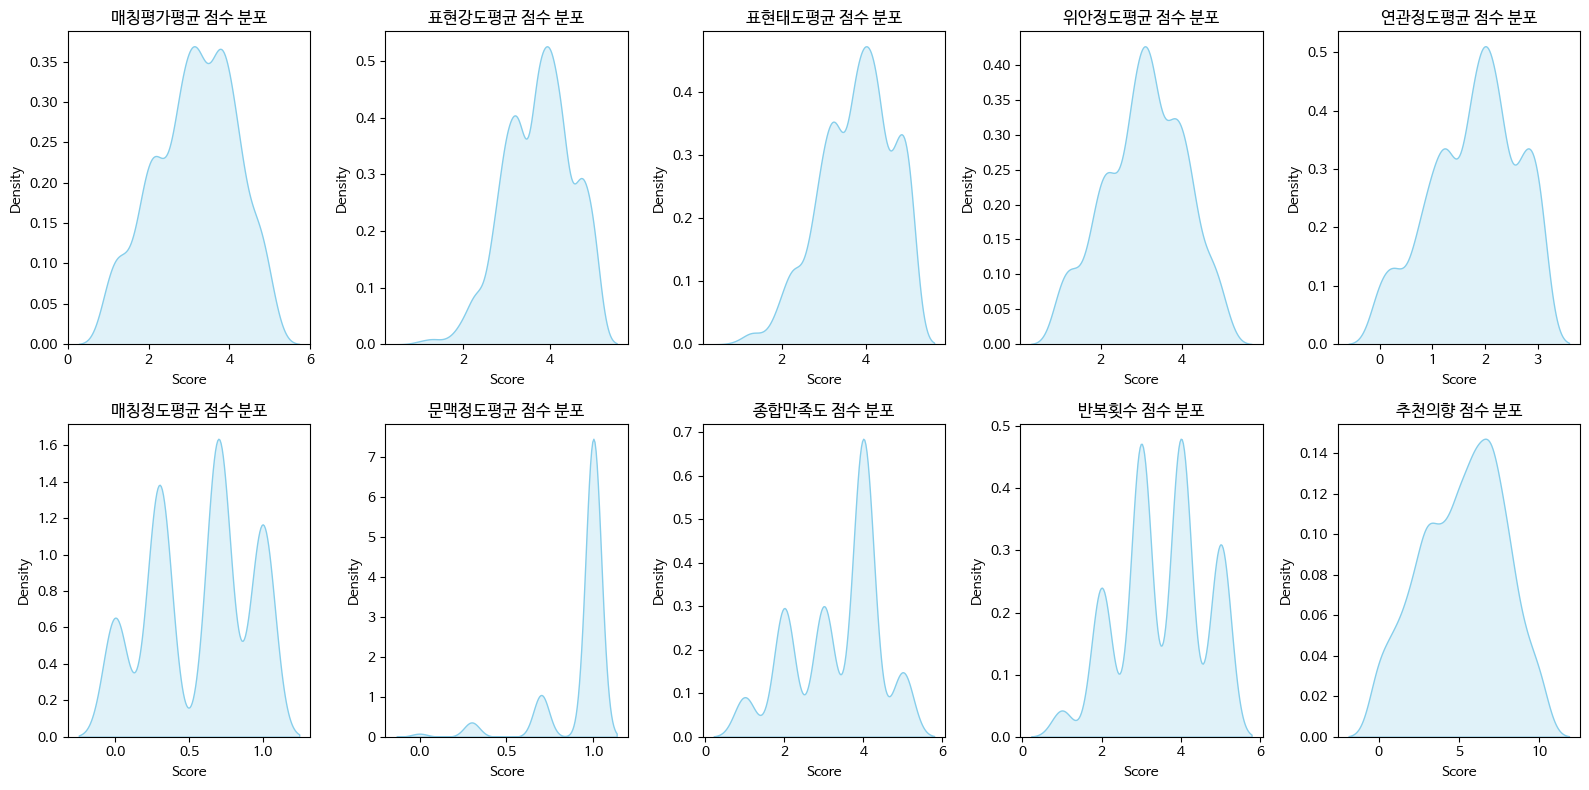

In [ ]:
# 사용자들의 각 평가 항목 평균 점수에 대한 분포
columns_to_plot = ['매칭평가평균', '표현강도평균', '표현태도평균', '위안정도평균', '연관정도평균', '매칭정도평균', '문맥정도평균', '종합만족도', '반복횟수', '추천의향']

num_rows = 2
num_cols = 5

plt.figure(figsize=(16, 8))

for i, column in enumerate(columns_to_plot):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.kdeplot(df[column], shade=True, color='skyblue')
    plt.title(column + ' 점수 분포')
    plt.xlabel('Score')

plt.tight_layout()
plt.show()

- 매칭평가 (1\~5): 5에 가까울 수록 평가 올바른 편
- 표현강도(1\~5): 강압 \~ 설득
- 표현태도 (1\~5): 딱딱 \~ 부드러움
- 위안정도 (1\~5): 5에 가까울 수록 위안 잘 되는 편
- 연관정도 (0\~3): 3에 가까울 수록 연관 잘 된 편
- 매칭정도 (0/1): No / Yes
- 문맥정도 (0/1): No / Yes (매칭 답변이 말이 되는지)
- 종합만족도 (1\~5): 5에 가까울 수록 의미있음
- 반복횟수 (1~\5): 5에 가까울 수록 만족하는 매칭 답변이 금방 나옴
- 추천의향 (0\~10): 10에 가까울 수록 추천

### 문맥 분석

In [ ]:
df.columns

Index(['날짜', '이메일', '만나이', '성별', '고민1', '매칭답변1', '매칭평가1', '표현강도1', '표현태도1',
       '위안정도1', '연관정도1', '매칭정도1', '문맥정도1', '고민2', '매칭답변2', '매칭평가2', '표현강도2',
       '표현태도2', '위안정도2', '연관정도2', '매칭정도2', '문맥정도2', '고민3', '매칭답변3', '매칭평가3',
       '표현강도3', '표현태도3', '위안정도3', '연관정도3', '매칭정도3', '문맥정도3', '종합만족도', '반복횟수',
       '추천의향', '만족이유', '만족답변', '불만족이유', '불만족답변', '만나이2', '매칭평가평균', '표현강도평균',
       '표현태도평균', '위안정도평균', '연관정도평균', '매칭정도평균', '문맥정도평균'],
      dtype='object')

In [ ]:
try_df = df[['이메일', '만나이', '성별', '고민1', '매칭답변1', '고민2', '매칭답변2', '고민3', '매칭답변3', '매칭평가평균', '표현강도평균',
       '표현태도평균', '위안정도평균', '연관정도평균', '매칭정도평균', '문맥정도평균', '종합만족도', '반복횟수', '추천의향', '만족이유', '만족답변', '불만족이유', '불만족답변']]
print(try_df.shape)
# try_df = try_df.sample(10)
try_df.head(3)

(1171, 23)


,이메일,만나이,성별,고민1,매칭답변1,고민2,매칭답변2,고민3,매칭답변3,매칭평가평균,...,연관정도평균,매칭정도평균,문맥정도평균,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변
0,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,먹는 양에 비해 음식 욕심이 많아요,댓글:음식을 먹는 것은 몸 안의 에너지를 보충하기 위한 행동입니다. 그런데 어떤 사...,잠에서 자주 깹니다.,댓글:꿈을 꾸면서 잠꼬대를 하는 것은 무의식이 의식에게 보내는 메시지입니다. 꿈속의...,3.7,...,0.7,0.7,1.0,4,3,6,1,NaN,0,NaN
1,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,수면장애,수면장애,피곤함,피곤함,4.7,...,3.0,1.0,1.0,4,1,0,0,NaN,2,고쳐지지않음
2,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,아이 키우는 것이 힘들어요.,나름 가까운곳에 착해질 기회가 있더라고요 그주위를 잘보는게 좋을거같아요~,이사를 해서 주변에 친구가 없어요.,아직 친구를 받아드리실 마음의 준비가 안되신 건 아닐까요? 그렇다면 좋은 친구들이 ...,3.0,...,1.7,0.3,1.0,4,4,7,2,아예 해결이 되는 답변은 아니지만 어느 정도 생각은 할 수 있게 해줌,0,NaN


----0929

In [ ]:
# try_df2 = df[['날짜', '성별', '고민1', '매칭답변1', '매칭평가1', '연관정도1', '매칭정도1', '문맥정도1',
#              '고민2', '매칭답변2', '매칭평가2', '연관정도2', '매칭정도2', '문맥정도2',
#              '고민3', '매칭답변3', '매칭평가3', '연관정도3', '매칭정도3', '문맥정도3',
#              '매칭평가평균', '연관정도평균', '매칭정도평균', '문맥정도평균', '종합만족도', '반복횟수', '만족이유', '만족답변', '불만족이유', '불만족답변']]

# print(try_df2.shape)
# # try_df2 = try_df2.sample(1171)
# try_df2.head(3)

Sentence Transformer 모델 사용하여 문맥상 유사도 계산. 이 모델은 각 문장을 임베딩으로 변환하고, 이를 사용하여 코사인 유사도를 계산함.

In [ ]:
# Sentence Transformer 모델 로딩
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [ ]:
# 매칭답변과 고민 간의 문맥상 유사도 계산 함수
def calculate_contextual_similarity(text1, text2):
    embeddings1 = model.encode(text1, convert_to_tensor=True)
    embeddings2 = model.encode(text2, convert_to_tensor=True)
    cosine_scores = util.pytorch_cos_sim(embeddings1, embeddings2)
    return cosine_scores.item()

In [ ]:
# 매칭답변과 고민 간의 문맥상 유사도 계산
for i in range(1, 4):
    try_df[f'st유사도{i}'] = try_df.apply(lambda row: calculate_contextual_similarity(row[f'고민{i}'], row[f'매칭답변{i}']), axis=1)

In [ ]:
try_df.head()

,이메일,만나이,성별,고민1,매칭답변1,고민2,매칭답변2,고민3,매칭답변3,매칭평가평균,...,종합만족도,반복횟수,추천의향,만족이유,만족답변,불만족이유,불만족답변,st유사도1,st유사도2,st유사도3
0,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,먹는 양에 비해 음식 욕심이 많아요,댓글:음식을 먹는 것은 몸 안의 에너지를 보충하기 위한 행동입니다. 그런데 어떤 사...,잠에서 자주 깹니다.,댓글:꿈을 꾸면서 잠꼬대를 하는 것은 무의식이 의식에게 보내는 메시지입니다. 꿈속의...,3.7,...,4,3,6,1,NaN,0,NaN,0.713660,0.807107,0.618481
1,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,수면장애,수면장애,피곤함,피곤함,4.7,...,4,1,0,0,NaN,2,고쳐지지않음,0.918442,1.000000,1.000000
2,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,아이 키우는 것이 힘들어요.,나름 가까운곳에 착해질 기회가 있더라고요 그주위를 잘보는게 좋을거같아요~,이사를 해서 주변에 친구가 없어요.,아직 친구를 받아드리실 마음의 준비가 안되신 건 아닐까요? 그렇다면 좋은 친구들이 ...,3.0,...,4,4,7,2,아예 해결이 되는 답변은 아니지만 어느 정도 생각은 할 수 있게 해줌,0,NaN,0.828257,0.896474,0.854746
3,chohyunkm@gmail.com,27,1,평소 한번 걱정을 하기 시작하면 끝도 없이 꼬리에 꼬리를 물고 걱정을 합니다.,저랑 비슷한 성격을 가지고 계시네요. 사실 소심한 성격 탓이 아닐 수 있어요. 다른...,아직 일어나지도 않은 일때문에 미리 겁을 먹고 불안해하며 밤에 자주 잠을 설쳐요.,오늘 밤은 아무 생각 하지 마시고 꿀잠 주무세요. 아직 일어나지 않은 일에 걱정하고...,사회생활 중 처음 만나는 사람과 어떻게 대화를 해야할지 잘 모르겠어요.,음...취미에 관련된 대화는 어떨까요? 여러 가지 대화를 통해 상대를 잘 알아 보아요!,3.3,...,2,4,1,0,NaN,2,현재의 다소 두루뭉술한 답변보다 좀 더 구체적인 해결법을 제시해줬으면 좋겠어요. \...,0.903890,0.983960,0.911473
4,ppoo8752@gmail.com,33,1,"한번 화가나면 흥분, 좌절, 슬픔의 감정이 오래 가요",OO님을 응원하는 사람들이 많아요 용기 잃지 마시고 OO님의 몸에 상처를 내지 마세요,가만히 있어도 불안하고 초조한 마음이 들어 답답해요,분명 누군가는 당신의 존재만으로도 너무행복하고 기쁘고 좋은 사람이 있을거에요. 엄마...,아이의 사소한 잘못에 짜증을 내고 화를 내요,서운한 마음을 속에 담아 두기 보다는 가끔은 글로 표현 해 보면 어떨까요? OO님의...,2.3,...,3,2,5,0,NaN,2,고민에 해당되는 답변이 아닌것 같고 영혼 없는 사무적인 느낌이라 공감받지 못한것 같...,0.920487,0.948822,0.902360


 Universal Sentence Encoder를 사용하여 문맥 유사도를 계산. 이 모델은 각 문장을 벡터로 변환하고, 이를 사용하여 코사인 유사도를 계산함.

In [ ]:
# Universal Sentence Encoder 로드
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# 문장을 벡터로 변환하는 함수
def sentence_to_vector(sentence):
    return embed([sentence])[0].numpy()

# 문맥 유사도 계산 함수
def context_similarity(row):
    # 매칭답변1과 고민1의 문맥 유사도 계산
    similarity_score_1 = cosine_similarity([sentence_to_vector(row['매칭답변1'])],
                                           [sentence_to_vector(row['고민1'])])[0][0]

    # 매칭답변2와 고민2의 문맥 유사도 계산
    similarity_score_2 = cosine_similarity([sentence_to_vector(row['매칭답변2'])],
                                           [sentence_to_vector(row['고민2'])])[0][0]

    # 매칭답변3과 고민3의 문맥 유사도 계산
    similarity_score_3 = cosine_similarity([sentence_to_vector(row['매칭답변3'])],
                                           [sentence_to_vector(row['고민3'])])[0][0]

    return pd.Series({
        'use유사도1': similarity_score_1,
        'use유사도2': similarity_score_2,
        'use유사도3': similarity_score_3,
    })

# try_df에 적용
try_df[['use유사도1', 'use유사도2', 'use유사도3']] = try_df.apply(context_similarity, axis=1)


In [ ]:
try_df.head()

,이메일,만나이,성별,고민1,매칭답변1,고민2,매칭답변2,고민3,매칭답변3,매칭평가평균,...,만족이유,만족답변,불만족이유,불만족답변,st유사도1,st유사도2,st유사도3,use유사도1,use유사도2,use유사도3
0,nwm21d@gmail.com,25,1,취업 준비를 어떻게 해야할 지 모르겠어요,댓글:우선 자신이 하고 싶은 일을 찾아야 합니다. 그리고 그 분야에서 요구하는 역량...,먹는 양에 비해 음식 욕심이 많아요,댓글:음식을 먹는 것은 몸 안의 에너지를 보충하기 위한 행동입니다. 그런데 어떤 사...,잠에서 자주 깹니다.,댓글:꿈을 꾸면서 잠꼬대를 하는 것은 무의식이 의식에게 보내는 메시지입니다. 꿈속의...,3.7,...,1,NaN,0,NaN,0.713660,0.807107,0.618481,0.369976,0.371686,0.063608
1,hana31146381@gmail.com,36,1,불면증,불면증 수면장애,수면장애,수면장애,피곤함,피곤함,4.7,...,0,NaN,2,고쳐지지않음,0.918442,1.000000,1.000000,0.460004,1.000000,1.000000
2,silverain515@gmail.com,34,1,일이 안 구해집니다.,어떤 분들도 늦은 나이에 새로운 일을 하시는 분들도 있다고 해요. 그러니 OO님은 ...,아이 키우는 것이 힘들어요.,나름 가까운곳에 착해질 기회가 있더라고요 그주위를 잘보는게 좋을거같아요~,이사를 해서 주변에 친구가 없어요.,아직 친구를 받아드리실 마음의 준비가 안되신 건 아닐까요? 그렇다면 좋은 친구들이 ...,3.0,...,2,아예 해결이 되는 답변은 아니지만 어느 정도 생각은 할 수 있게 해줌,0,NaN,0.828257,0.896474,0.854746,0.259560,0.456789,0.331890
3,chohyunkm@gmail.com,27,1,평소 한번 걱정을 하기 시작하면 끝도 없이 꼬리에 꼬리를 물고 걱정을 합니다.,저랑 비슷한 성격을 가지고 계시네요. 사실 소심한 성격 탓이 아닐 수 있어요. 다른...,아직 일어나지도 않은 일때문에 미리 겁을 먹고 불안해하며 밤에 자주 잠을 설쳐요.,오늘 밤은 아무 생각 하지 마시고 꿀잠 주무세요. 아직 일어나지 않은 일에 걱정하고...,사회생활 중 처음 만나는 사람과 어떻게 대화를 해야할지 잘 모르겠어요.,음...취미에 관련된 대화는 어떨까요? 여러 가지 대화를 통해 상대를 잘 알아 보아요!,3.3,...,0,NaN,2,현재의 다소 두루뭉술한 답변보다 좀 더 구체적인 해결법을 제시해줬으면 좋겠어요. \...,0.903890,0.983960,0.911473,0.484082,0.561993,0.589436
4,ppoo8752@gmail.com,33,1,"한번 화가나면 흥분, 좌절, 슬픔의 감정이 오래 가요",OO님을 응원하는 사람들이 많아요 용기 잃지 마시고 OO님의 몸에 상처를 내지 마세요,가만히 있어도 불안하고 초조한 마음이 들어 답답해요,분명 누군가는 당신의 존재만으로도 너무행복하고 기쁘고 좋은 사람이 있을거에요. 엄마...,아이의 사소한 잘못에 짜증을 내고 화를 내요,서운한 마음을 속에 담아 두기 보다는 가끔은 글로 표현 해 보면 어떨까요? OO님의...,2.3,...,0,NaN,2,고민에 해당되는 답변이 아닌것 같고 영혼 없는 사무적인 느낌이라 공감받지 못한것 같...,0.920487,0.948822,0.902360,0.470306,0.536226,0.449463


Text(0, 0.5, '인원수(명)')

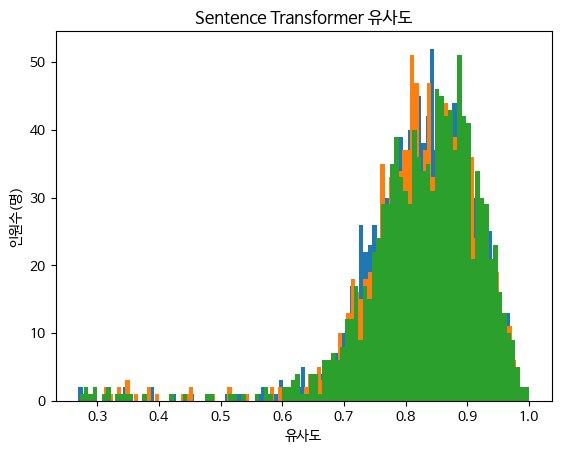

In [ ]:
plt.hist(try_df['st유사도1'],bins=100)
plt.hist(try_df['st유사도2'],bins=100)
plt.hist(try_df['st유사도3'],bins=100)
plt.title('Sentence Transformer 유사도')
plt.xlabel('유사도')
plt.ylabel('인원수(명)')

Text(0, 0.5, '인원수(명)')

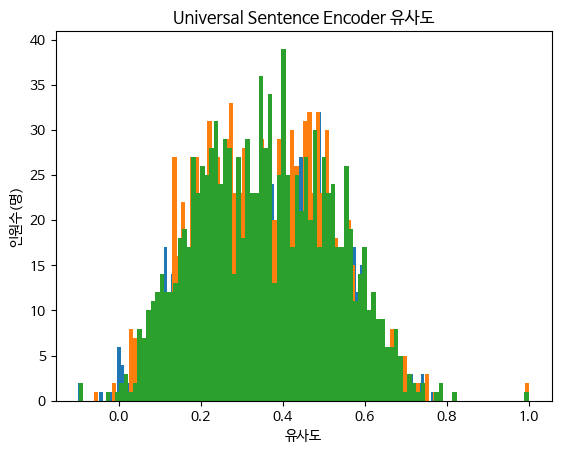

In [ ]:
plt.hist(try_df['use유사도1'],bins=100)
plt.hist(try_df['use유사도2'],bins=100)
plt.hist(try_df['use유사도3'],bins=100)

plt.title('Universal Sentence Encoder 유사도')
plt.xlabel('유사도')
plt.ylabel('인원수(명)')

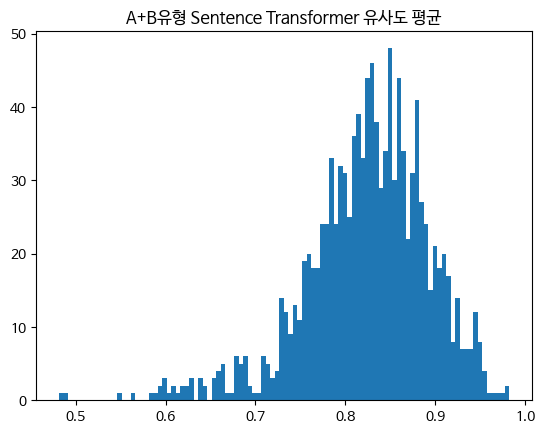

In [ ]:
plt.hist(try_df[['st유사도1', 'st유사도2', 'st유사도3']].mean(axis=1),bins=100)
plt.title('A+B유형 Sentence Transformer 유사도 평균')
plt.show()

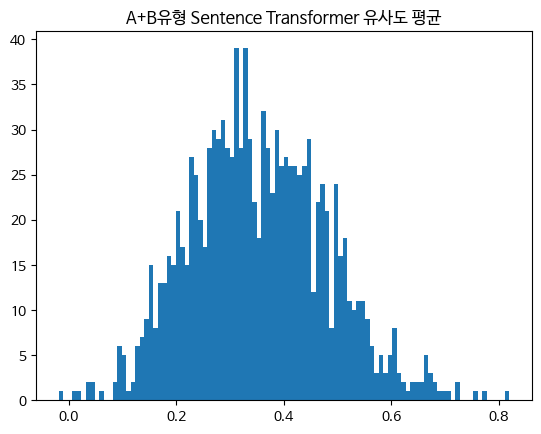

In [ ]:
plt.hist(try_df[['use유사도1', 'use유사도2', 'use유사도3']].mean(axis=1),bins=100)
plt.title('A+B유형 Universal Transformer 유사도 평균')
plt.show()

In [ ]:
try_df['st_mean'] = try_df[['st유사도1', 'st유사도2', 'st유사도3']].mean(axis=1)
try_df['use_mean'] = try_df[['use유사도1', 'use유사도2', 'use유사도3']].mean(axis=1)

print(round(try_df['st_mean'].mean(), 2), round(try_df['use_mean'].mean(), 2))

0.82 0.35


In [ ]:
print(round(try_df['st_mean'].mean(), 2), round(try_df['use_mean'].mean(), 2))

0.82 0.35


결과의 차이-GPT
각 모델의 결과는 '문맥상_유사도' 및 '문맥유사도' 컬럼에 저장되어 있습니다. 결과의 차이는 모델이 다른 임베딩을 사용하고 있기 때문입니다. 두 모델은 다른 사전 훈련된 임베딩 모델을 사용하고 있으며, 따라서 문장을 다르게 이해하고 유사도를 계산합니다.  


어떤 모델이 더 좋은지는 목표 및 사용 사례에 따라 다를 수 있습니다. Sentence Transformer는 대규모 데이터셋에서 훈련된 모델이고, Universal Sentence Encoder는 다양한 유형의 문장에 대해 훈련된 모델입니다. 따라서 문장의 특성 및 목적에 따라 적합한 모델을 선택해야 합니다.  

예를 들어, Universal Sentence Encoder는 다양한 유형의 텍스트에 대해 효과적이지만, Sentence Transformer는 문장 임베딩을 더 세부적으로 조정하여 특정 작업에 더 적합할 수 있습니다. 실험 및 사용 사례에 따라 어떤 모델이 더 성능이 좋은지 확인해 보시기를 권장합니다.

### 텍스트마이닝

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import networkx as nx

In [ ]:
df_text = concat_df.copy()
# df = df.head(10)
df_text = df_text[['이메일', '성별', '만족이유', '만족답변', '불만족이유', '불만족답변']]
# df_text.columns
df_text.head(2)

,이메일,성별,만족이유,만족답변,불만족이유,불만족답변
0,nwm21d@gmail.com,1,1,NaN,0,NaN
1,hana31146381@gmail.com,1,0,NaN,2,고쳐지지않음


In [ ]:
df_text['불만족이유'].value_counts()

0    422
2    419
1    330
Name: 불만족이유, dtype: int64

In [ ]:
print(len(df_text), df_text['불만족답변'].isna().sum())

1171 731


1173명 중 442명이 불만족한 이유에 대한 답변을 입력해줌

#### 단어 빈도 분석

In [ ]:
# 텍스트 데이터 전처리
# 불만족 답변 컬럼을 대상으로 텍스트 마이닝 수행
df_text_complaints = df_text['불만족답변'].dropna()  # NaN 값 제거
df_text_complaints

1                                                 고쳐지지않음
3      현재의 다소 두루뭉술한 답변보다 좀 더 구체적인 해결법을 제시해줬으면 좋겠어요. \...
4      고민에 해당되는 답변이 아닌것 같고 영혼 없는 사무적인 느낌이라 공감받지 못한것 같...
5                      아직 매칭된 이야기가 정확하지 않아 위로나 설득이 되지 않음
6      아직은 고민을 100%이해하지 못하는것 같아요. 3가지 고민중 2가지가 다른 매칭이...
                             ...                        
531                               답변이 올바르지 않을때가 많고 너무 느림
532    기존의 입력되어 있는 문장을 가져다 보여준다는 느낌이 오늘 따라 많이 드네요. 표현...
539    내가 한 고민과 전혀 다른 이야기가 답변으로 적혀 있어서 한 치의 도움도 받지 못했다. 
540                         질문 내용에 대해 답변 얻기가 대체로 어렵습니다..
541    세 가지의 질문 주에서 내가 도움을 받은 고민은 한 가지뿐이었다. 두 가지는 질문과...
Name: 불만족답변, Length: 440, dtype: object

In [ ]:
# 단어 빈도 분석을 위한 벡터화
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_text_complaints)

# 단어 빈도수 계산
word_freq = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

In [ ]:
# 상위 빈도수 단어 추출
top_words = word_freq.sum().sort_values(ascending=False).head(10)

# 상위 빈도수 단어 출력
print("상위 빈도수 단어:")
print(top_words)

상위 빈도수 단어:
답변이     132
너무       93
대한       64
고민에      63
고민과      45
같습니다     44
답변을      43
고민       38
답변       36
전혀       35
dtype: int64


#### N-gram 분석

In [ ]:
# N-gram 분석(2-gram)
# N-gram 모델 생성
ngram_vectorizer = CountVectorizer(ngram_range=(2, 2))
X_ngram = ngram_vectorizer.fit_transform(df_text_complaints)

# N-gram 단어 빈도수 계산
ngram_freq = pd.DataFrame(X_ngram.toarray(), columns=ngram_vectorizer.get_feature_names_out())

# 상위 빈도수 N-gram 출력
top_ngram = ngram_freq.sum().sort_values(ascending=False).head(10)
print("\n상위 빈도수 N-gram:")
print(top_ngram)


상위 빈도수 N-gram:
고민에 대한      35
맞지 않는       20
대한 답변이      16
답변이 너무      12
답변이 나오지     11
매칭된 이야기가    10
전혀 다른       10
질문에 대한       9
관련 없는        7
고민과 전혀       7
dtype: int64


In [ ]:
# N-gram 분석(3-gram)
# N-gram 모델 생성
ngram_vectorizer = CountVectorizer(ngram_range=(3, 3))
X_ngram = ngram_vectorizer.fit_transform(df_text_complaints)

# N-gram 단어 빈도수 계산
ngram_freq = pd.DataFrame(X_ngram.toarray(), columns=ngram_vectorizer.get_feature_names_out())

# 상위 빈도수 N-gram 출력
top_ngram = ngram_freq.sum().sort_values(ascending=False).head(10)
print("\n상위 빈도수 N-gram:")
print(top_ngram)


상위 빈도수 N-gram:
고민에 대한 답변이    10
고민과 전혀 다른      3
대한 답변이 너무      3
맥락에 맞지 않는      3
고민에 대한 답변을     3
전혀 다른 답변이      3
답변이 나오지 않는     3
맞는 답변이 나오지     3
맞지 않는 답변       2
전혀 상관 없는       2
dtype: int64


#### 워드 클라우드

**만족**

In [ ]:
# 만족답변
a1=list(concat_df['만족답변'].dropna().values)
b1=' '.join(a1)

In [ ]:
# 형태소 분석기 초기화
okt = Okt()

# 문장을 형태소로 분석하여 명사만 추출
words = okt.nouns(b1)

# 단어 빈도 계산
word_freq = Counter(words)

# 빈도가 가장 높은 단어 순으로 상위 N개 출력
top_words = word_freq.most_common(30)  # 상위 5개 단어를 찾음

# 결과 출력
for word, freq in top_words:
    print(f'단어: {word}, 빈도: {freq}')

단어: 고민, 빈도: 176
단어: 답변, 빈도: 168
단어: 것, 빈도: 103
단어: 생각, 빈도: 74
단어: 수, 빈도: 73
단어: 말, 빈도: 66
단어: 마음, 빈도: 61
단어: 이야기, 빈도: 60
단어: 위로, 빈도: 58
단어: 위안, 빈도: 47
단어: 답, 빈도: 43
단어: 해결, 빈도: 42
단어: 대한, 빈도: 42
단어: 매칭, 빈도: 42
단어: 사람, 빈도: 40
단어: 때, 빈도: 35
단어: 질문, 빈도: 35
단어: 더, 빈도: 32
단어: 도움, 빈도: 30
단어: 느낌, 빈도: 30
단어: 점, 빈도: 27
단어: 내, 빈도: 26
단어: 조금, 빈도: 26
단어: 제시, 빈도: 23
단어: 다른, 빈도: 22
단어: 나, 빈도: 22
단어: 상담, 빈도: 21
단어: 부분, 빈도: 21
단어: 문장, 빈도: 20
단어: 대답, 빈도: 20


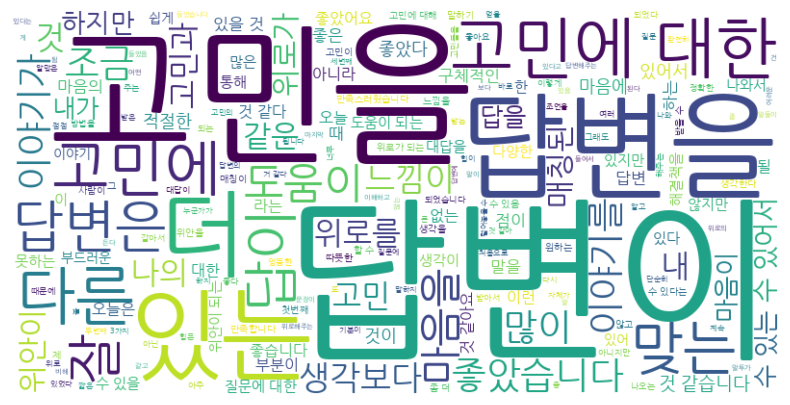

In [ ]:
# 하나의 긴 문장을 변수에 저장
# 워드클라우드 생성
font="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
wordcloud = WordCloud(font_path=font,width=800, height=400, background_color='white').generate(b1)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

**불만족**

In [ ]:
# 불만족답변
a=list(concat_df['불만족답변'].dropna().values)
b=' '.join(a)

In [ ]:
# 형태소 분석기 초기화
okt = Okt()

# 문장을 형태소로 분석하여 명사만 추출
words = okt.nouns(b)

# 단어 빈도 계산
word_freq = Counter(words)

# 빈도가 가장 높은 단어 순으로 상위 N개 출력
top_words = word_freq.most_common(30)  # 상위 5개 단어를 찾음

# 결과 출력
for word, freq in top_words:
    print(f'단어: {word}, 빈도: {freq}')


단어: 답변, 빈도: 340
단어: 고민, 빈도: 276
단어: 것, 빈도: 136
단어: 질문, 빈도: 94
단어: 매칭, 빈도: 92
단어: 이야기, 빈도: 89
단어: 내용, 빈도: 83
단어: 대한, 빈도: 66
단어: 답, 빈도: 65
단어: 경우, 빈도: 62
단어: 문장, 빈도: 62
단어: 단어, 빈도: 48
단어: 생각, 빈도: 46
단어: 때, 빈도: 45
단어: 대답, 빈도: 44
단어: 말, 빈도: 40
단어: 느낌, 빈도: 38
단어: 더, 빈도: 37
단어: 전혀, 빈도: 37
단어: 수, 빈도: 36
단어: 다른, 빈도: 31
단어: 상담, 빈도: 31
단어: 번, 빈도: 31
단어: 관련, 빈도: 30
단어: 위로, 빈도: 29
단어: 해결, 빈도: 28
단어: 가지, 빈도: 26
단어: 조금, 빈도: 26
단어: 내, 빈도: 25
단어: 도움, 빈도: 24


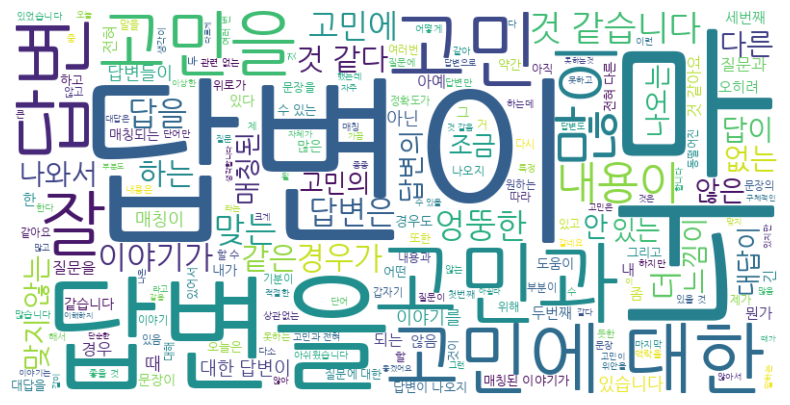

In [ ]:
# 하나의 긴 문장을 변수에 저장
# 워드클라우드 생성
font="/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
wordcloud = WordCloud(font_path=font,width=800, height=400, background_color='white').generate(b)

# 워드클라우드 시각화
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

만족과 불만족한 이유에 대한 답변이 너무 진부함.